## Part 5: XGBoost Benchmarking ＆ Model Evaluation

## 1. Model Development
### 1.1 Data Preparation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [ ]:
# Load required data
# drop the 'price' column as it was only there for use in generating knn features before
X_train = pd.read_csv("D:\\Desktop\\DSS5104\\final\\engineered_categorical_train_knn.csv").drop(columns=["price"])  
y_train = pd.read_csv("D:\\Desktop\\DSS5104\\final\\train_data.csv")["log10_price"]# log10 price for training

# Load test features and true price
X_test = pd.read_csv("D:\\Desktop\\DSS5104\\final\\engineered_categorical_test_knn.csv")
y_test = pd.read_csv("D:\\Desktop\\DSS5104\\final\\test_data.csv")["price"]  # actual price for evaluation

In [17]:
# print the column names
print(X_train.columns)
print(X_test.columns)

# Ensure train/test have same columns
assert list(X_train.columns) == list(X_test.columns), "Train/Test column mismatch!"

# check the shape of each dataset
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Index(['house_age', 'years_since_last_action', 'was_renovated',
       'sqft_living_per_floor', 'sqft_basement_ratio', 'sqft_living_lot_ratio',
       'total_rooms_approx', 'log_sqft_living', 'log_sqft_lot',
       'log_sqft_above', 'log_sqft_basement', 'sqft_living_sq',
       'bed_bath_interaction', 'age_sqft_interaction', 'city_encoded',
       'statezip_encoded', 'knn_avg_price_5'],
      dtype='object')
Index(['house_age', 'years_since_last_action', 'was_renovated',
       'sqft_living_per_floor', 'sqft_basement_ratio', 'sqft_living_lot_ratio',
       'total_rooms_approx', 'log_sqft_living', 'log_sqft_lot',
       'log_sqft_above', 'log_sqft_basement', 'sqft_living_sq',
       'bed_bath_interaction', 'age_sqft_interaction', 'city_encoded',
       'statezip_encoded', 'knn_avg_price_5'],
      dtype='object')
X_train shape: (3641, 17)
X_test shape: (911, 17)
y_train shape: (3641,)
y_test shape: (911,)


### 1.2 Cross-validation strategy

In [62]:
# Set Cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model
baseline_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# Cross-validation RMSE(on training set)
cv_rmse = cross_val_score(baseline_model, X_train, np.power(10, y_train), scoring='neg_root_mean_squared_error', cv=kf)
# Cross-validation Mape(on training set)
cv_mape = cross_val_score(baseline_model, X_train, np.power(10, y_train), scoring='neg_mean_absolute_percentage_error', cv=kf)
print("Baseline CV RMSE scores:", -cv_rmse)
print("Baseline Mean CV RMSE:", -cv_rmse.mean())
print("Baseline CV MAPE scores:", -cv_mape)
print("Baseline Mean CV MAPE:", -cv_mape.mean())

Baseline CV RMSE scores: [252427.05920349 986876.82832066 299209.02122818 446510.52492324
 195888.5430918 ]
Baseline Mean CV RMSE: 436182.39535347465
Baseline CV MAPE scores: [0.19292399 0.19517511 0.21656935 0.29090706 0.19797289]
Baseline Mean CV MAPE: 0.21870967760211588


### 1.3 XGBoost Baseline Model

In [63]:
# Fit baseline model
baseline_model.fit(X_train, y_train)

# Predict on test set
y_preds = baseline_model.predict(X_test)
# Convert predictions back to original scale
y_preds_actual = np.power(10, y_preds)

# Save predictions
submission = pd.DataFrame({'Id': X_test.index, 'Prediction': y_preds_actual})
submission.to_csv('xgboost_predictions.csv', index=False)

# Evaluate model performance
mse = mean_squared_error(y_test, y_preds_actual)#use actual price for evaluation
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_preds_actual)
print(f"Test RMSE: {rmse}")
print(f"Test MAPE: {mape}")
mape_percentage = mape * 100 #convert the performance metrics to percentage, 2format
print(f"Test MAPE percentage: {mape_percentage:.2f}%")

Test RMSE: 460037.2543602411
Test MAPE: 0.18597737821388818
Test MAPE percentage: 18.60%


### 1.3 Model Tuning

In [66]:
# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), param_grid, 
                    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                    refit='neg_root_mean_squared_error',  # choose the metric to optimize
                    cv=kf, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Print the best parameters and score
print("Best RMSE from Grid Search:", -grid.best_score_)
print("Best MAPE from Grid Search:", -grid.cv_results_['mean_test_neg_mean_absolute_percentage_error'][grid.best_index_])
print("Best params from Grid Search:", grid.best_params_)

# Final model re-training with best params
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

# Predict on test set with best model
y_preds_best = best_model.predict(X_test)
y_preds_best_actual = 10 ** y_preds_best

# Evaluate best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_preds_best_actual))
mape_best = mean_absolute_percentage_error(y_test, y_preds_best_actual)
print(f"[Best Model] Test RMSE: {rmse_best:.2f}")
print(f"[Best Model] Test MAPE: {mape_best:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best RMSE from Grid Search: 0.10783171089794008
Best MAPE from Grid Search: 0.01262562731295468
Best params from Grid Search: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
[Best Model] Test RMSE: 463220.41
[Best Model] Test MAPE: 0.1866


## 2.Model Performance Visualization ＆ Analysis

### 2.1 Model Predictions Visualization

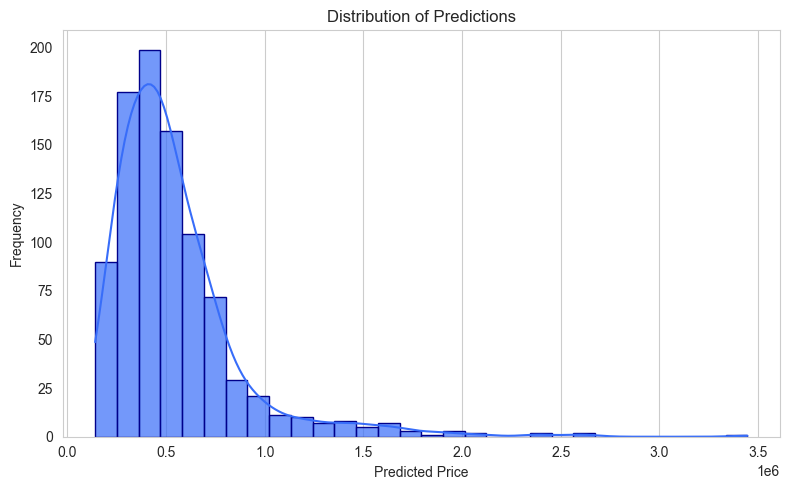

In [55]:
# show the distribution of the predictions
plt.figure(figsize=(8, 5))
sns.histplot(y_preds_best_actual, bins=30, kde=True, edgecolor='darkblue', alpha=0.7)
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Price")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Figure : Distribution of XGBoost Model's Price Predictions**

- The histogram illustrates the distribution of predicted house prices from our XGBoost model. The distribution shows a clear right-skewed pattern, with the majority of predictions concentrated between $300,000 and $1,000,000. 

- The peak frequency occurs around $500,000, with approximately 200 predictions in this range. The long right tail extends to $3.5 million, indicating relatively few predictions for high-value properties. 

- This distribution pattern aligns with typical real estate market structures, where mid-range properties dominate the market while luxury properties represent a smaller segment.


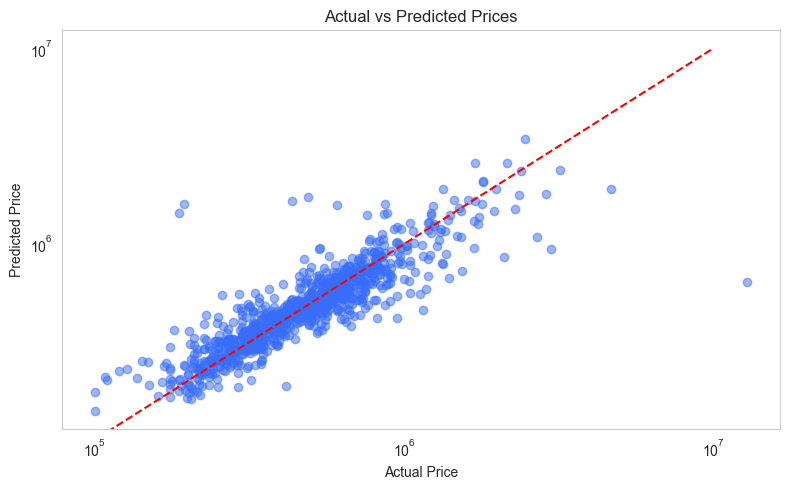

In [44]:
# Plot actual vs predicted prices
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_preds_best_actual, alpha=0.5)
plt.plot([0, 1e7], [0, 1e7], 'r--')  # diagonal line
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.show()

**Figure: Actual vs Predicted House Prices (Log Scale)**

- The scatter plot compares actual house prices against XGBoost model predictions on a logarithmic scale. 
- The red dashed line represents perfect predictions (y=x), while each blue point represents a house in the test set. The points generally cluster around the diagonal line, indicating good predictive performance across most price ranges. The logarithmic scale reveals the model's behavior across different price segments, from approximately $100,000 to $10 million. 
- The spread of points appears relatively consistent along the diagonal, though with some increased scatter at higher price ranges, suggesting the model maintains reasonable accuracy across the price spectrum while showing slightly higher variance in predictions for luxury properties.

### 2.2 Residual Analysis

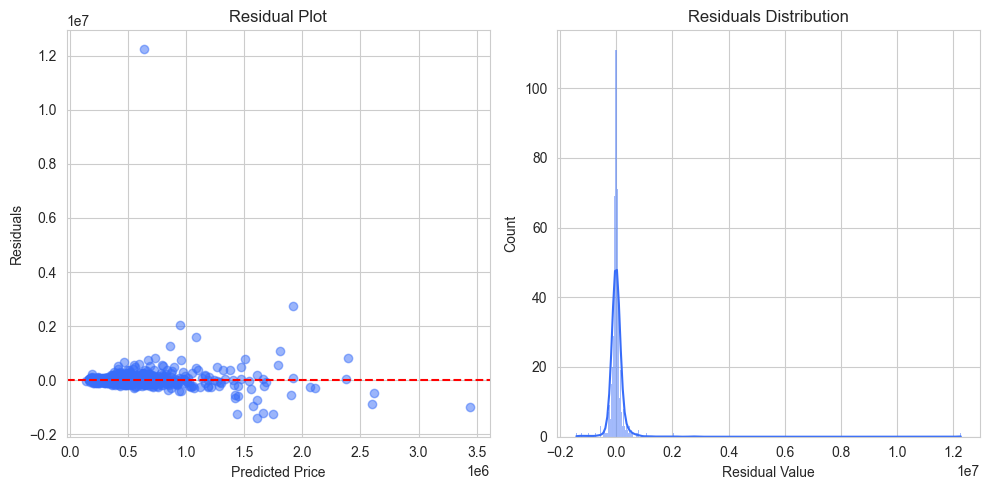

In [56]:
# 计算并可视化残差
residuals = y_test - y_preds_best_actual
plt.figure(figsize=(10, 5))

# 残差图
plt.subplot(1, 2, 1)
plt.scatter(y_preds_best_actual, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# 残差分布
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual Value')
plt.tight_layout()
plt.show()

**Figure: Residual Analysis of XGBoost Model Predictions**

- This figure presents two complementary views of the model's prediction residuals. 
- The left panel shows the residual plot, where residuals are plotted against predicted prices (in millions). The red dashed line at y=0 represents perfect predictions, with points scattered relatively symmetrically around this line, particularly in the lower price ranges (0-1.5M). 
- The right panel displays the distribution of residuals, showing a sharp peak near zero with symmetric tails, suggesting that most prediction errors are small and normally distributed. 
- A few outliers are visible in both plots, particularly for higher-priced properties, but the overall pattern indicates the model's predictions are generally unbiased across the price spectrum.

### 2.3 Feature Importance in XGBoost Model

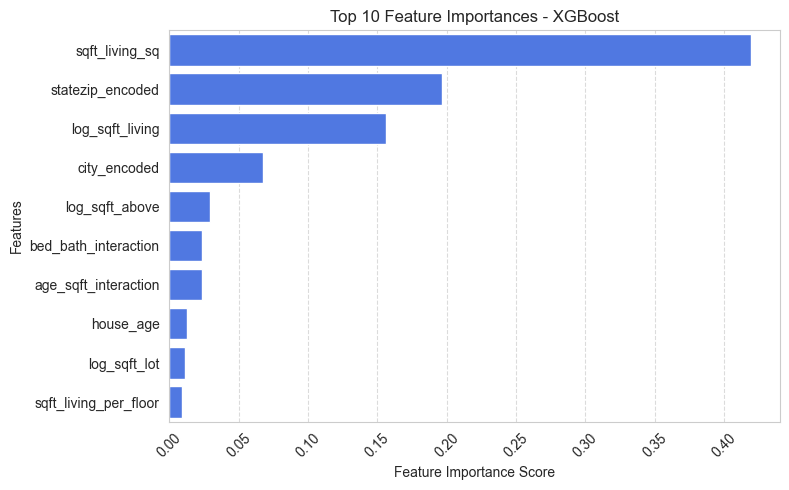

In [71]:
# Plot top 10 important features
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()

#make the plot more readable
plt.xticks(rotation=45)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)

#beautify the plot
plt.tight_layout()
sns.set_palette("rainbow")
sns.set_style("whitegrid")
plt.show()

**Figure : Top 10 Feature Importances**

- This visualization displays the top 10 most influential features in our XGBoost model, ranked by their importance scores. 
- The squared living area (sqft_living_sq) emerges as the dominant predictor with a score of approximately 0.4, followed by location-based features (statezip_encoded and city_encoded) and other size-related features (log_sqft_living, log_sqft_above). 
- Notably, the engineered interaction features (bed_bath_interaction and age_sqft_interaction) also appear in the top 10, though with lower importance scores. 
- This hierarchy of features reveals how the XGBoost model primarily relies on property size and location characteristics for price prediction.

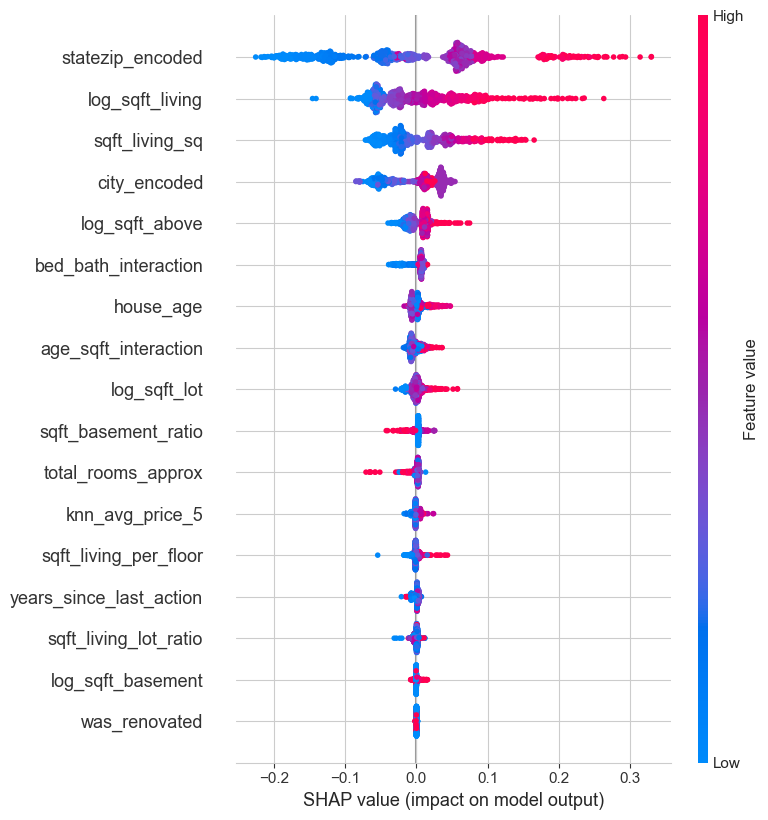

In [54]:
# SHAP analysis
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

**Figure: SHAP Summary Plot for House Price Prediction Model**

- This plot illustrates the impact of different features on house price predictions. 

- The x-axis shows SHAP values (impact on model output), while the y-axis lists features ordered by their importance from top to bottom. Each point represents a sample, with colors ranging from blue (low) to red (high) indicating feature values. The horizontal position of points shows whether the feature has a positive (right) or negative (left) impact on predictions.

- The most influential features are statezip_encoded, log_sqft_living, and sqft_living_sq. The distribution patterns and color transitions reveal non-linear relationships between feature values and their impacts. Features at the top have larger and more dispersed SHAP values, indicating stronger influence on the model's predictions.

## 3.More Model Analysis

### 3.1 Price Range Performance Analysis

**To understand how the model performs in different price ranges**

- This analysis segments houses into five price ranges and evaluates the model's prediction accuracy within each segment. The mean percentage error, standard deviation, and sample count are reported for each range. 

In [72]:
# Create price ranges and analyze the performance of each range
def analyze_by_price_range(y_true, y_pred):
    df = pd.DataFrame({'actual': y_true, 'predicted': y_pred})
    df['price_range'] = pd.qcut(df['actual'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    df['abs_error'] = abs(df['actual'] - df['predicted'])
    df['percentage_error'] = (df['abs_error'] / df['actual']) * 100
    
    return df.groupby('price_range').agg({
        'percentage_error': ['mean', 'std', 'count']
    }).round(2)

price_range_performance = analyze_by_price_range(y_test, y_preds_best_actual)
print("\nPerformance by Price Range:")
print(price_range_performance)


Performance by Price Range:
            percentage_error             
                        mean    std count
price_range                              
Very Low               28.44  72.79   190
Low                    13.32  12.63   176
Medium                 15.81  30.25   182
High                   13.78  14.40   181
Very High              21.30  18.12   182


C:\Users\86159\AppData\Local\Temp\ipykernel_6604\1878069835.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('price_range').agg({


- The results reveal that the model's performance varies across price segments:

- The model performs best in the Low and High price ranges, with mean percentage errors of 13.32% and 13.78% respectively. However, it struggles most with Very Low-priced properties (28.44% error) and Very High-priced properties (21.30% error), suggesting reduced prediction accuracy at the extremes of the price spectrum. The large standard deviation in the Very Low segment (72.79%) indicates particularly volatile predictions for the lowest-priced properties. The relatively balanced count across segments (176-190 houses per category) ensures the reliability of these comparisons.

- This pattern suggests that this model performs reasonably well for mid-market properties, while it may need refinement to better handle properties at both ends of the price spectrum, particularly those in the lowest price range where prediction uncertainty is highest.

#### 3.2 Prediction Error Analysis

**To identify specific cases where predictions deviate most significantly, offering insights for model comparison.**

- This analysis examines the 10 specific cases with the largest prediction errors, spanning properties from $188,000 to $12.9M, showing how key features interact in challenging predictions.

In [73]:
# get top 10 features
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10).index

# define analyze_worst_predictions function
def analyze_worst_predictions(y_true, y_pred, X_test, n=10):
    errors = abs(y_true - y_pred)
    worst_indices = np.argsort(errors)[-n:]
    
    analysis_df = pd.DataFrame({
        'Actual': y_true[worst_indices],
        'Predicted': y_pred[worst_indices],
        'Error': errors[worst_indices],
        'Error%': (errors[worst_indices] / y_true[worst_indices]) * 100
    })
    
    # add top 10 features for each worst prediction cases
    for feature in top_10_features:
        analysis_df[feature] = X_test[feature].iloc[worst_indices]
    
    return analysis_df.sort_values('Error%', ascending=False)

# analyze worst predictions
worst_predictions = analyze_worst_predictions(y_test, y_preds_best_actual, X_test)
print("\nWorst Predictions Analysis:")
print(worst_predictions)
print("Model's top 10 most important features:"+ top_10_features)


Worst Predictions Analysis:
         Actual    Predicted         Error      Error%  sqft_living_sq  \
823    195000.0  1607676.625  1.412677e+06  724.449551        28515600   
865    188000.0  1440186.250  1.252186e+06  666.056516        10627600   
128    435000.0  1661312.625  1.226313e+06  281.910948        18147600   
267    490000.0  1751486.375  1.261486e+06  257.446199        19891600   
120  12899000.0   638034.125  1.226097e+07   95.053616         4796100   
682   3000000.0   949720.500  2.050280e+06   68.342650        23522500   
706   2700000.0  1089539.250  1.610461e+06   59.646694        19536400   
819   2110000.0   864087.625  1.245912e+06   59.047980        10432900   
23    4668000.0  1921943.125  2.746057e+06   58.827268        92929600   
323   2888000.0  1806019.625  1.081980e+06   37.464694        75168900   

     statezip_encoded  log_sqft_living  city_encoded  log_sqft_above  \
823      5.663226e+05         8.583168  5.705159e+05        8.227108   
865      2.3

- For each case, we display the actual price, predicted price, absolute and percentage errors, along with their corresponding feature values. Each of them displays their values across important model features such as sqft_living_sq, location encodings (statezip_encoded, city_encoded), and property characteristics (bed_bath_interaction, house_age). 

- The results reveal interesting patterns in how the model handles different property types: properties with large living areas (e.g., 28,515 sq ft) and certain location encodings tend to see significant deviations; moderate-priced homes($188,000-$490,000) with large square footage tend to receive higher predictions, while luxury properties($2.1M-$12.9M) show distinct prediction patterns based on their unique combinations of location (statezip_encoded) and size features. 